# Speed Profile at Intersections and Acceptability
Date Created: Oct 14, 2019

Last Modified: Oct 18, 2019 by SH


The algorithm:
1. Gets a driving style profile for each intersection based on four variables
2. Compares the intersection speed profiles betaween the AV and human drivers per intersection type per driving condition
3. Calculated Mahalanobis distance between between the AV & humans per intersection per driving condition
 - To cllculate Mahalanobis distance, we fit a distribution to AV driving measures per intersection per driving condition and compute the distance of each individual 4-D style to the corresponding AV distribution. 

4. It then looks at the spearman correlation of acc median and subscale median with the mahalanobis distance

#### Initialization

In [463]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [464]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
from os import listdir
import math

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

#### Choosing the participant group we are going to look at: "Completed all" 
As reported in Master_Data_List//Quanlitative//Demographics.xls -> Sheet: Master Data -> Column: Participant Status

In [465]:
# setting the path to the qualitative data master list
Qualitative_Path = ("N:\Shabnam Haghzare\\01- AV_OA_Study\\Master_Data_List\\Qualitative\\")

# reading the demographic data into a dataframe--- index = participant ID, colums = feature label
Demographics = pd.read_excel(Qualitative_Path + "Demographics.xlsx", sheet_name = "Master Data")
Demographics = Demographics.set_index('Participant ID')

In [466]:
# grouping participants based on their study completion status
status = Demographics.groupby('Participant Status')
completed_IDs = np.array(status.groups['All Completed'])[3:]

Analyzed_IDs = completed_IDs
print("Number of included participants in this analysis:", len(Analyzed_IDs) )
Analyzed_IDs


Number of included participants in this analysis: 36


array([13, 17, 19, 20, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37,
       38, 40, 42, 43, 44, 45, 46, 47, 49, 51, 54, 56, 58, 60, 61, 62, 63,
       64, 66], dtype=int64)

### Quick demographics

In [467]:
Analyzed_demographics = Demographics.loc[Analyzed_IDs]
Analyzed_demographics.mean()

Age                                   73.250000
Years of Driving Experience           52.194444
MoCA Score                            27.555556
Visual Acuity Score (LogMAR)_Right     0.254837
Visual Acuity Score (LogMAR)_Left      0.257459
Total Mood Disturbance               -25.000000
dtype: float64

In [468]:
Analyzed_demographics.std()

Age                                   5.963580
Years of Driving Experience           8.827941
MoCA Score                            1.992048
Visual Acuity Score (LogMAR)_Right    0.230717
Visual Acuity Score (LogMAR)_Left     0.158125
Total Mood Disturbance                9.689464
dtype: float64

In [469]:
female_male_ratio = (Analyzed_demographics[Analyzed_demographics["Sex"]=="F"].shape[0])/(Analyzed_demographics[Analyzed_demographics["Sex"]=="M"].shape[0])
female_male_ratio

0.7142857142857143

# !!!DELETE THE FOLLOWING CELL WHEN TA scenario fo 34 & 58 are solved!!!

In [470]:
Analyzed_IDs = Analyzed_IDs[(Analyzed_IDs!=34) & (Analyzed_IDs !=58)]
Analyzed_IDs

array([13, 17, 19, 20, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 36, 37, 38,
       40, 42, 43, 44, 45, 46, 47, 49, 51, 54, 56, 60, 61, 62, 63, 64, 66],
      dtype=int64)

In [471]:
## Setting the path to Quantitative Data
Quantitative_path = "N:\\Shabnam Haghzare\\01- AV_OA_Study\\Master_Data_List\\Quantitative"

In [472]:
#for ID in Analyzed_IDs:
#    ID = int(ID)
#    for scenario in ["BM", "BA", "RM", "RA","TM", "TA"]:

__Step I. Getting intersections__

- Intersections will be defined as -300 meter to 300 meter before and after each intersection.
- Each scenario has three intersections; the IDs in the simulator_data are:

{Intersection ID : Turn Type } = {2: Left, 9: Right, 13:Straight}


Each of the "left_intersection"; "right_intersection"; and "straight_intersection" include 600 meters around each instersection. 

__We would like to have four variables describing each intersection:__
1. M_acc = Mean Acceleration (m/s^2)
2. M_dec = Mean Decelaration (m/s^2)
3. duration_zero = duratin of speed less than 3 m/s (sec)
4. D_minspeed = Distance to Intersection at Minimum Speed (m)

__Function Space__

In [473]:
def get_intersections_from_simulator_output(simulator_output):
    
    # Input: simulator_output read as a DataFrame
    # Output: x3 DataFrames that are the intersection segments of the simulator_output.df 
        # Left intersection: intersection ID=2
        # right intersection: intersection ID=9
        # straight intersection: intersection ID=13
    
    id_2_intersection     = simulator_output[simulator_output["Intersection Id"] == 2];
    id_9_intersection     = simulator_output[simulator_output["Intersection Id"] == 9];
    id_13_intersection     = simulator_output[simulator_output["Intersection Id"] == 13];

    id_2_median  = id_2_intersection["Distance_travelled"].median()
    id_9_median  = id_9_intersection["Distance_travelled"].median()
    id_13_median = id_13_intersection["Distance_travelled"].median()

    left_intersection     = simulator_output[((id_2_median-300)<simulator_output["Distance_travelled"]) & (simulator_output["Distance_travelled"]<(id_2_median+300))]
    right_intersection    = simulator_output[((id_9_median-300)<simulator_output["Distance_travelled"]) & (simulator_output["Distance_travelled"]<(id_9_median+300))]
    straight_intersection = simulator_output[(simulator_output["Distance_travelled"]<(id_13_median-300)) & (simulator_output["Distance_travelled"]<(id_13_median+300))]
        
    return(left_intersection, right_intersection, straight_intersection, id_2_median, id_9_median, id_13_median)

In [474]:
## defining a function that spits out the four measurements for each intersection dataframe
def get_intersection_variables(intersection_df, median):
    
    #input: dataframe of each intersection, i.e., a segmnent o fsimulator output
    #output: 4 measures characterising the driving style of the intersection
    
    #1 mean acceleration
    acc_x_mean = intersection_df[intersection_df["CoG Acceleration/X"]>0]["CoG Acceleration/X"].mean()
    acc_y_mean = intersection_df[intersection_df["CoG Acceleration/Y"]>0]["CoG Acceleration/Y"].mean()
    M_acc =  math.sqrt(acc_x_mean**2 + acc_y_mean**2) 
    
    #2 mean deceleration
    dec_x_mean = intersection_df[intersection_df["CoG Acceleration/X"]<0]["CoG Acceleration/X"].mean()
    dec_y_mean = intersection_df[intersection_df["CoG Acceleration/Y"]<0]["CoG Acceleration/Y"].mean()
    M_dec = - math.sqrt(dec_x_mean**2 + dec_y_mean**2) 

    #3 duration of speed less than 3 m/s 
    #time_when_speed_less_than_3 = intersection_df[intersection_df["Speed/X"]<=3]["Time"];
    #duration_zero = time_when_speed_less_than_3.max()- time_when_speed_less_than_3.min()
    
    ## Second try:
    intersection_close_to_median = intersection_df[(intersection_df["Distance_travelled"]>=median-20)& intersection_df["Distance_travelled"]<=median+20]
    min_speed_close_to_median = intersection_close_to_median["Speed/X"].min()
    time_at_min_speed = intersection_close_to_median[intersection_close_to_median["Speed/X"]<=min_speed_close_to_median + 0.7]["Time"]
    duration_zero = time_at_min_speed.max() - time_at_min_speed.min()
    
    #4 distance to intersection at minimum speed # meters
    D_at_min_speed = intersection_df[intersection_df['Speed/X'] == intersection_df['Speed/X'].min()]["Distance_travelled"].values
    D_minspeed     = (median - D_at_min_speed)[0] #meters
    
    return(M_acc, M_dec, duration_zero, D_minspeed)

## TEST

ID = 66; scenario = "RA"
scenario_path_Structured = Quantitative_path + "\\" + str(ID) + "\\Structured\\Simulator\\" + scenario 
simulator_output_csv = pd.read_csv(scenario_path_Structured + "\\" + scenario + "_simulator_outputs.csv")
        
select_variables_csv = simulator_output_csv.loc[:,
                    ["Time","Intersection Id", "Speed/X", "CoG Acceleration/X", "CoG Acceleration/Y"]]
        
# adding the measure distance
Time = simulator_output_csv["Time"][1:].to_numpy();
Time_shifted = simulator_output_csv["Time"][:len(Time)].to_numpy();
delta_time = Time - Time_shifted;
speed_np = simulator_output_csv["Speed/X"].to_numpy()[1:]
distance = (delta_time*speed_np).cumsum()
        
select_variables_csv.insert(loc = 2,column = "Distance_travelled", value =np.pad(distance,((1,0)), mode = 'constant'))
        #time in sec # acceleration in m/s2 # speed in m/s
        
#now we segment the simulator output to three sub-segments of 
left_intersection, right_intersection, straight_intersection,L_median, R_median, S_median = get_intersections_from_simulator_output(select_variables_csv)

#L_measures = get_intersection_variables(left_intersection, L_median)

time_when_speed_less_than_3 = right_intersection[right_intersection["Speed/X"]<=0.7]["Time"];
duration_zero = time_when_speed_less_than_3.max()- time_when_speed_less_than_3.min()

right_intersection.plot(x = "Time", y = "Speed/X")

### We will need x3 multi-index dataframs with the same structure for each type of intersection: 
1. left_df, 
2. right_df, and
3. straight_df

In [475]:
#Initializing the dataframes
columns = pd.MultiIndex.from_product([["Clear Daytime", "Rainy Daytime", "Traffic Daytime"], 
                                     ["Auto", "Manual"],
                                     ["mean acceleration", "mean deceleration", "duration", "distance"]], 
                                     names=["Driving Condition", "LoA", "measures"]);
index = Analyzed_IDs.astype(int);

left_df = pd.DataFrame(index=index, columns=columns)
right_df = pd.DataFrame(index=index, columns=columns)
straight_df = pd.DataFrame(index=index, columns=columns)

In [476]:
for ID in Analyzed_IDs:
    ID = int(ID)
    for scenario in ["BM", "BA", "RM", "RA","TM", "TA"]:
        scenario_path_Structured = Quantitative_path + "\\" + str(ID) + "\\Structured\\Simulator\\" + scenario 
        simulator_output_csv = pd.read_csv(scenario_path_Structured + "\\" + scenario + "_simulator_outputs.csv")
        
        select_variables_csv = simulator_output_csv.loc[:,
                    ["Time","Intersection Id", "Speed/X", "CoG Acceleration/X", "CoG Acceleration/Y"]]
        
        # adding the measure distance
        Time = simulator_output_csv["Time"][1:].to_numpy();
        Time_shifted = simulator_output_csv["Time"][:len(Time)].to_numpy();
        delta_time = Time - Time_shifted;
        speed_np = simulator_output_csv["Speed/X"].to_numpy()[1:]
        distance = (delta_time*speed_np).cumsum()
        
        select_variables_csv.insert(loc = 2,column = "Distance_travelled", value =np.pad(distance,((1,0)), mode = 'constant'))
        #time in sec # acceleration in m/s2 # speed in m/s
        
        #now we segment the simulator output to three sub-segments of 
        left_intersection, right_intersection, straight_intersection,L_median, R_median, S_median = get_intersections_from_simulator_output(select_variables_csv)

        L_measures = get_intersection_variables(left_intersection, L_median)
        R_measures = get_intersection_variables(right_intersection, R_median)
        S_measures = get_intersection_variables(straight_intersection, S_median)
        
        if scenario =="BM":
            left_df.loc[ID]["Clear Daytime"]["Manual"] = L_measures
            right_df.loc[ID]["Clear Daytime"]["Manual"] = R_measures
            straight_df.loc[ID]["Clear Daytime"]["Manual"] = S_measures
            
        elif scenario =="BA":
            left_df.loc[ID]["Clear Daytime"]["Auto"] = L_measures
            right_df.loc[ID]["Clear Daytime"]["Auto"] = R_measures
            straight_df.loc[ID]["Clear Daytime"]["Auto"] = S_measures
                
        elif scenario == "RM":
            left_df.loc[ID]["Rainy Daytime"]["Manual"] = L_measures
            right_df.loc[ID]["Rainy Daytime"]["Manual"] = R_measures
            straight_df.loc[ID]["Rainy Daytime"]["Manual"] = S_measures
                    
        elif scenario == "RA":
            left_df.loc[ID]["Rainy Daytime"]["Auto"] = L_measures
            right_df.loc[ID]["Rainy Daytime"]["Auto"] = R_measures
            straight_df.loc[ID]["Rainy Daytime"]["Auto"] = S_measures
                        
        elif scenario == "TM":
            left_df.loc[ID]["Traffic Daytime"]["Manual"] = L_measures
            right_df.loc[ID]["Traffic Daytime"]["Manual"] = R_measures
            straight_df.loc[ID]["Traffic Daytime"]["Manual"] = S_measures
                            
        elif scenario == "TA":
            left_df.loc[ID]["Traffic Daytime"]["Auto"] = L_measures
            right_df.loc[ID]["Traffic Daytime"]["Auto"] = R_measures
            straight_df.loc[ID]["Traffic Daytime"]["Auto"] = S_measures
                                
                            
                            

In [477]:
left_df.fillna(0, inplace = True)
straight_df.fillna(0, inplace = True)
right_df.fillna(0, inplace = True)

In [478]:
right_df

Driving Condition     Clear Daytime                                        \
LoA                            Auto                                         
measures          mean acceleration mean deceleration duration   distance   
13                         0.530279         -0.722361   51.421  23.150288   
17                         0.692553         -1.484987   11.941  20.883304   
19                         0.573866         -0.846691   50.780  23.026175   
20                         0.579995         -0.760559   52.621  23.133938   
22                         0.705906         -1.859469    5.870  21.227466   
23                         0.594110         -0.861199   38.940  23.140864   
25                         0.576186         -0.834801   48.410  23.155060   
26                         0.776364         -2.057953    0.990  21.316274   
27                         0.472433         -0.659563   67.230  23.167374   
28                         0.830225         -2.126931    0.840  21.559832   
30                         0.528589         -0.850325   35.090  22.555668   
31                         0.531710         -0.709149   60.550  23.110994   
32                         0.537020         -0.803773   45.240  23.134385   
33                         0.772548         -2.061220    1.030  21.161023   
36                         0.512554         -0.632036   64.491  23.171433   
37                         0.525624         -0.874688   34.821  22.830641   
38                         0.786555         -1.850927    2.370  21.620135   
40                         0.544515         -0.821820   34.510  23.131746   
42                         0.535030         -0.685395   58.321  23.169261   
43                         0.753662         -2.018150    1.160  21.120628   
44                         0.482818         -0.609287   65.090  23.177905   
45                         0.492779         -0.622160   63.401  23.142050   
46                         0.643488         -0.950997   46.910  23.090296   
47                         0.516829         -0.661636   58.040  23.168549   
49                         0.527640         -0.847463   34.551  23.111625   
51                         0.775537         -2.020963    1.060  21.256351   
54                         0.760849         -2.036375    1.100  21.101103   
56                         0.539436         -0.832720   34.510  23.162019   
60                         0.575512         -0.812586   50.231  23.140805   
61                         0.571450         -0.829085   51.320  22.983545   
62                         0.541551         -0.638904   57.161  23.125955   
63                         0.570052         -0.878401   34.710  22.950525   
64                         0.570134         -0.866862   55.731  59.667603   
66                         0.638092         -0.966659   34.531  23.131500   

Driving Condition                                                           \
LoA                          Manual                                          
measures          mean acceleration mean deceleration duration    distance   
13                         0.764479         -0.825032   1.4000  112.132333   
17                         1.321571         -0.775090   1.8600   33.295821   
19                         0.754185         -0.839871   4.7600  105.579125   
20                         0.885389         -1.273119  34.0002    0.534537   
22                         0.652512         -0.744030   2.0000  106.952456   
23                         0.950661         -0.688153  22.2800  108.977257   
25                         0.977025         -0.745167  19.8600  112.160498   
26                         1.236283         -2.822730   2.0500  103.907207   
27                         0.916220         -0.673656   1.2900  111.316106   
28                         0.662712         -0.671931   1.3900  107.788469   
30                         1.205613         -1.044660  18.1103  109.323187   
31                         0.759195         -0.924332   3.

#### For Each driving Condition: Calculating 4-D Mahalanobis Distance of each individual/intersection from the automated distribution in that intersection

__First:__ we need distributions fitted to the auto driving styles per intersection per driving condition
i.e., we need 9 pairs of 4-d mu vectors and 4x4 covariance matrices

#### So the Mahalobis distance is a dataframe with two leevels of columns: 1. turns & 2. driving conditions

In [629]:
#Initializing the mahalobis dataframes
columns = pd.MultiIndex.from_product([["Left Turn","Straight Turn", "Right Turn"],
                                      ["Clear Daytime", "Rainy Daytime", "Traffic Daytime"]], 
                                     names=["Type of Intersection", "Driving Condition"]);
index = Analyzed_IDs.astype(int);

mahalobis = pd.DataFrame(index=index, columns=columns, dtype = float)
mahalobis = mahalobis.astype(float)

In [630]:
## function of mahalanobis distance
def calculate_mahalanobis_distance(x, mu, cov):
    invcov = np.linalg.inv(cov)
    x_mu = x-mu
    help_var = np.matmul(x_mu ,invcov)
    d_2      = np.matmul(help_var, x_mu.T)
    d      = math.sqrt(d_2)
    
    if d>=80:
        d = "Nan"
    
    return d

__Second Step:__ is to get calculate the distance of each 4-d individual driving style from its correponsing auto distribution

In [631]:
for turns in ["Left Turn","Straight Turn", "Right Turn"]:
    for conditions in ["Clear Daytime", "Rainy Daytime", "Traffic Daytime"]:
        
        ## get the distribution of the Auto per turn per condition
        # & get the correspnding data ponts from manual drivers:
        if turns == "Left Turn":
            mu = left_df[conditions]["Auto"].mean().values
            cov  = left_df[conditions]["Auto"].cov().values
            
            X = left_df[conditions]["Manual"]
            
        elif turns == "Straight Turn":
            mu = straight_df[conditions]["Auto"].mean().values
            cov  = straight_df[conditions]["Auto"].cov().values
            
            X = straight_df[conditions]["Manual"]
            
        elif turns == "Right Turn":
            mu = right_df[conditions]["Auto"].mean().values
            cov  = right_df[conditions]["Auto"].cov().values
            
            X = right_df[conditions]["Manual"]
            
            ## now we get the corresponding data points from individuals' driving styles
        for ID in Analyzed_IDs:
            x = X.loc[ID].values #each data point
            mahalobis.at[ID, (turns, conditions)] = calculate_mahalanobis_distance(x, mu, cov)

In [632]:
#mahalobis[mahalobis>145]=0

mahalobis

Type of Intersection     Left Turn                                \
Driving Condition    Clear Daytime Rainy Daytime Traffic Daytime   
13                        3.077892      1.593078       11.562261   
17                       10.528423     22.705621       11.501221   
19                        8.498288      4.096397        5.510819   
20                        1.485108      3.066798       21.045073   
22                        6.928205      7.182021        8.168990   
23                       12.573720     13.331677        7.177812   
25                        7.802008      2.450459        8.581948   
26                        6.347198     10.046593        9.682372   
27                       25.088290     49.192192        4.380723   
28                        0.635683      3.380086       12.079847   
30                       28.298087     16.762128       22.386381   
31                        5.731301     22.915517       30.498089   
32                        7.864927      6.642368        5.415548   
33                       11.616844      7.035336       10.268350   
36                        7.935368     17.997140       19.575991   
37                       10.155879      4.432054        8.338250   
38                       16.182902     19.061871       15.752957   
40                       24.612510     11.853198       16.966310   
42                       14.560081      2.703998       11.895010   
43                       19.255451      9.220664       37.040545   
44                       12.153988     26.924902       34.290427   
45                       10.222056     16.869047       21.192124   
46                        4.183294      7.781201        6.250952   
47                        9.605791      5.439413       12.477884   
49                        9.023044      1.941861        4.744124   
51                        1.985890      7.105911       11.289637   
54                        4.968986      4.680086        6.944364   
56                       19.037623     10.592121        2.428923   
60                        4.262228      8.074995        4.692329   
61                        5.158823      8.401742        4.923804   
62                       14.418068     13.973552       14.432141   
63                       23.076193      3.346089       43.374173   
64                       13.011526     14.458864        7.648752   
66                        6.653303     13.964987        8.050891   

Type of Intersection Straight Turn                                \
Driving Condition    Clear Daytime Rainy Daytime Traffic Daytime   
13                        7.445402     15.284652       17.588526   
17                       30.810947     14.975603       14.826211   
19                        7.336284      8.087407       12.853946   
20                        6.757351     16.073904        9.379373   
22                        5.928913      6.157055       11.855631   
23                       17.057992     10.439209       11.659347   
25                       18.003577      8.804635       16.938004   
26                       22.320260      5.017552       13.697487   
27                       16.318949     20.837274       12.793164   
28                        7.227440     13.364694       16.760266   
30                       20.965225     13.472195       23.164822   
31                        6.487773      9.048222       15.292832   
32                       13.983228     10.053269       15.555389   
33                        6.668680      8.146515       16.449009   
36                       17.203959      8.071236        9.086651   
37                       13.811862     10.830166       12.994125   
38                       34.939959      5.935651       20.774602   
40                        9.606658     14.630165        5.482131   
42                       15.575765     18.689943       11.661058   
43                       20.520202      9.745586       13.881598   
44                       11.260425     13.561353       

### Finally we will plot three categorical violin plots for each turn-- categories: driving conditions

In [633]:
import seaborn as sns
my_pal = {'Clear Daytime':'mediumaquamarine', 'Rainy Daytime':'cadetblue', 'Traffic Daytime': 'darksalmon'}

Text(0.5, 1.0, 'Right Turn')

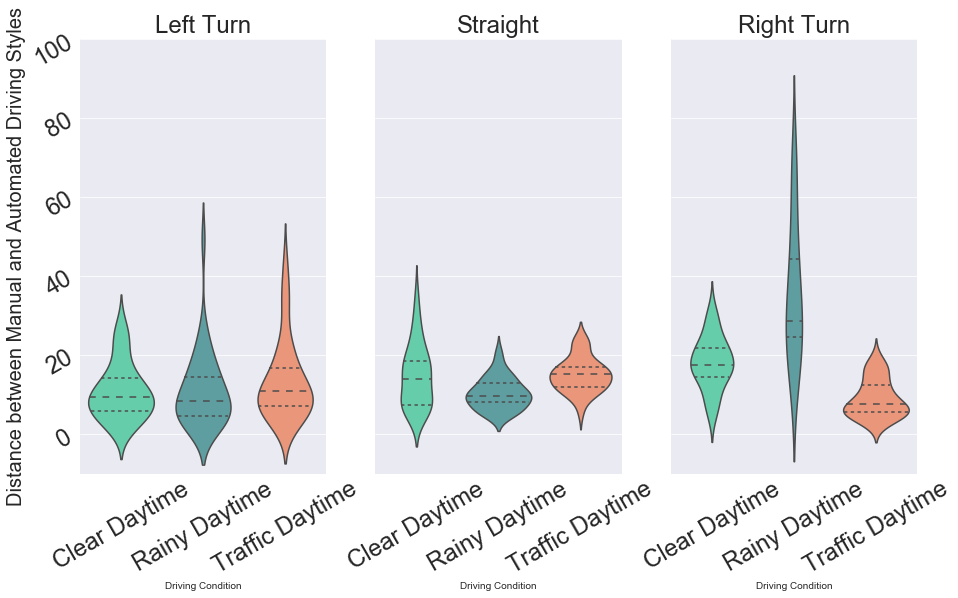

In [634]:
figure, axes = plt.subplots(1,3, figsize = (15,8), sharey= True)

axes[0].set_ylim(-10,100)

sns.violinplot(data=mahalobis["Left Turn"], palette=my_pal, inner = "quartile",  ax = axes[0], saturation = 1)
sns.violinplot(data=mahalobis["Straight Turn"], palette=my_pal, inner = "quartile",  ax = axes[1], saturation = 1)
sns.violinplot(data=mahalobis["Right Turn"], palette=my_pal, inner = "quartile",  ax = axes[2], saturation = 1)

axes[0].set_ylabel("Distance between Manual and Automated Driving Styles",fontsize=20)
axes[0].tick_params(labelsize=24, rotation=30)
axes[0].set_title("Left Turn",fontsize=24)

axes[1].tick_params(labelsize=24,rotation=30)
axes[1].set_title("Straight",fontsize=24)

axes[2].tick_params(labelsize=24,rotation=30)
axes[2].set_title("Right Turn",fontsize=24)


### Acceptability & Difference of Style

In [635]:
# Reading the acceptability scores of Analyzed IDs

# setting the path to the qualitative data master list
Qualitative_Path = ("N:\Shabnam Haghzare\\01- AV_OA_Study\\Master_Data_List\\Qualitative\\")

def read_acc_questionnaire(excel, worksheet, AVAM):
    df = pd.read_excel(Qualitative_Path + excel + ".xlsx", sheet_name = worksheet)
    df.columns = df.loc[0,:]
    df.drop(index = 0)
    df = df.set_index('Participant ID')
    df = df.drop(index = 'Participant ID')
    
    if AVAM == True:
        df['dangerous'] = list(8 - df['dangerous'])
        df['Concerns'] = list(8 - df['Concerns'])
        df['Frightening'] = list(8 - df['Frightening'])
        df["don't understand"] = list(8 - df["don't understand"])
        
    ## Looking only into the ones picked for analysis
    #Analyzed_IDs_2 = np.sort(np.concatenate((completed_IDs, ss_incompleted_IDs)))
    Analyzed_df = df.loc[Analyzed_IDs].dropna()
    
    return df, Analyzed_df

# reading the acceptance masterlist into a dataframe--- index = participant ID, colums = feature label
ACC_master, Analyzed_ACC_master = read_acc_questionnaire("AcceptabilityQuestionnaires", "Acceptability_MasterList", False)

# Pre-exposure acceptability questionnaire
ACC_PRE, Analyzed_ACC_PRE       = read_acc_questionnaire("AcceptabilityQuestionnaires", "PRE", False)

# Post exposure acceptability questionnaire
ACC_POST, Analyzed_ACC_POST     = read_acc_questionnaire("AcceptabilityQuestionnaires", "POST", False)

# Rain acceptability questionnaire - and inversing one item in the percieved safety scale
ACC_Rain, Analyzed_ACC_Rain     = read_acc_questionnaire("AcceptabilityQuestionnaires", "Acceptability_Rain", True)

# Normal questionnaire - and inversing one item in the percieved safety scale
ACC_Norm, Analyzed_ACC_Norm      = read_acc_questionnaire("AcceptabilityQuestionnaires", "Acceptability_Normal", True)

# Traffic questionnaire - and inversing one item in the percieved safety scale
ACC_Trfc, Analyzed_ACC_Traffic     = read_acc_questionnaire("AcceptabilityQuestionnaires", "Acceptability_Traffic", True)


### Median Acceptability

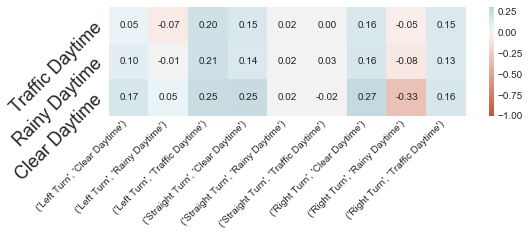

In [636]:
### making a dataframe with columns of Median Acceptability of each drivin gcondition

index = Analyzed_IDs.astype(int);

N = Analyzed_ACC_Norm.drop(columns = ["Date", "Status"]).astype("float").median(1)
R = Analyzed_ACC_Rain.drop(columns = ["Date", "Status"]).astype("float").median(1)
T = Analyzed_ACC_Traffic.drop(columns = ["Date", "Status"]).astype("float").median(1)

d = {"Clear Daytime": N, "Rainy Daytime":R, "Traffic Daytime":T }

ACC_median_per_condition = pd.DataFrame(index=index, dtype = float, data = d)
ACC_maha_concat = pd.concat([ACC_median_per_condition, mahalobis],1)
corr_matrix = ACC_maha_concat.corr(method= "spearman")

condition_key = ["Clear Daytime", "Rainy Daytime", "Traffic Daytime"]
cropped_corr_matrix = corr_matrix.drop(columns =condition_key).loc[condition_key]
cropped_corr_matrix = cropped_corr_matrix.reindex(index=cropped_corr_matrix.index[::-1])


fig, ax = plt.subplots(figsize=(8, 2))
sns.heatmap(cropped_corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, fmt='.2f',
           vmin=-1, vmax=0.3, center = 0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize = 18);

### Acceptability subscales

In [637]:
PE_scale_items = ['quickly','Cost efficiently','Safely']
EE_scale_items = ['Easy to Use','Clear & Understandable','Easy to learn']
SI_scale_items = ['Proud to show','Widely Used','Passengers']
FC_scale_items = ['Control Over the Journey','Knowledge Necessary','Infrastructure']
AT_scale_items = ['Good idea','More Interesting','Fun']
SE_scale_items = ['Built-in assistance','no assistance','help of a person']
AN_scale_items = ['Concerns','Frightening',"don't understand"]
IU_scale_items = ['Predict to use','plan to obtain']
PS_scale_items = ['dangerous','feel safe','trust']

## Percieved Safety (PS)

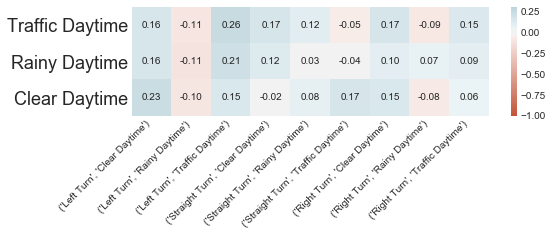

In [638]:
index = Analyzed_IDs.astype(int);

N = Analyzed_ACC_Norm.drop(columns = ["Date", "Status"]).astype("float")[PS_scale_items].median(1)
R = Analyzed_ACC_Rain.drop(columns = ["Date", "Status"]).astype("float")[PS_scale_items].median(1)
T = Analyzed_ACC_Traffic.drop(columns = ["Date", "Status"]).astype("float")[PS_scale_items].median(1)

d = {"Clear Daytime": N, "Rainy Daytime":R, "Traffic Daytime":T }

PS_median_per_condition = pd.DataFrame(index=index, dtype = float, data = d)
PS_maha_concat = pd.concat([PS_median_per_condition, mahalobis],1)
corr_matrix = PS_maha_concat.corr(method= "spearman")

condition_key = ["Clear Daytime", "Rainy Daytime", "Traffic Daytime"]
cropped_corr_matrix = corr_matrix.drop(columns =condition_key).loc[condition_key]
cropped_corr_matrix = cropped_corr_matrix.reindex(index=cropped_corr_matrix.index[::-1])


fig, ax = plt.subplots(figsize=(8, 2))
sns.heatmap(cropped_corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, fmt='.2f',
           vmin=-1, vmax=0.3, center = 0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize = 18);

### Anxiety Scale

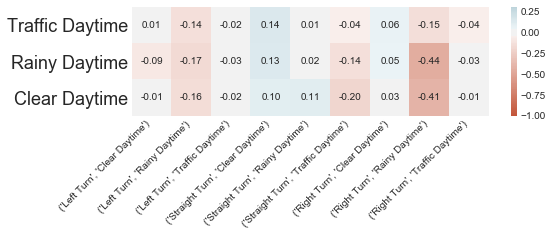

In [642]:
index = Analyzed_IDs.astype(int);

N = Analyzed_ACC_Norm.drop(columns = ["Date", "Status"]).astype("float")[AN_scale_items].median(1)
R = Analyzed_ACC_Rain.drop(columns = ["Date", "Status"]).astype("float")[AN_scale_items].median(1)
T = Analyzed_ACC_Traffic.drop(columns = ["Date", "Status"]).astype("float")[AN_scale_items].median(1)

d = {"Clear Daytime": N, "Rainy Daytime":R, "Traffic Daytime":T }

AN_median_per_condition = pd.DataFrame(index=index, dtype = float, data = d)
AN_maha_concat = pd.concat([AN_median_per_condition, mahalobis],1)
corr_matrix = AN_maha_concat.corr(method= "spearman")

condition_key = ["Clear Daytime", "Rainy Daytime", "Traffic Daytime"]
cropped_corr_matrix = corr_matrix.drop(columns =condition_key).loc[condition_key]
cropped_corr_matrix = cropped_corr_matrix.reindex(index=cropped_corr_matrix.index[::-1])


fig, ax = plt.subplots(figsize=(8, 2))
sns.heatmap(cropped_corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, fmt='.2f',
           vmin=-1, vmax=0.3, center = 0)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize = 18);

## Intention to Use

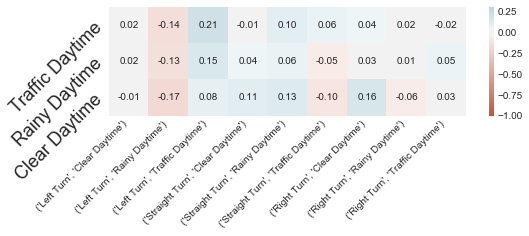

In [578]:
index = Analyzed_IDs.astype(int);

N = Analyzed_ACC_Norm.drop(columns = ["Date", "Status"]).astype("float")[IU_scale_items].median(1)
R = Analyzed_ACC_Rain.drop(columns = ["Date", "Status"]).astype("float")[IU_scale_items].median(1)
T = Analyzed_ACC_Traffic.drop(columns = ["Date", "Status"]).astype("float")[IU_scale_items].median(1)

d = {"Clear Daytime": N, "Rainy Daytime":R, "Traffic Daytime":T }

IU_median_per_condition = pd.DataFrame(index=index, dtype = float, data = d)
IU_maha_concat = pd.concat([IU_median_per_condition, mahalobis],1)
corr_matrix = IU_maha_concat.corr(method= "spearman")

condition_key = ["Clear Daytime", "Rainy Daytime", "Traffic Daytime"]
cropped_corr_matrix = corr_matrix.drop(columns =condition_key).loc[condition_key]
cropped_corr_matrix = cropped_corr_matrix.reindex(index=cropped_corr_matrix.index[::-1])

fig, ax = plt.subplots(figsize=(8, 2))

sns.heatmap(cropped_corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, fmt='.2f',
           vmin=-1, vmax=0.3, center = 0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize = 18);

### References
[1] Lee, J. D., Liu, S. Y., Domeyer, J., & DinparastDjadid, A. (2019). Assessing Drivers’ Trust of Automated Vehicle Driving Styles With a Two-Part Mixed Model of Intervention Tendency and Magnitude. Human Factors, 0018720819880363.